# Figures

Random figures needed for other things

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# L = np.pi
# h = 2

# x = np.linspace(-L, L, 1000)
# # f = lambda x: h * np.where((-L <= x) & (x <= -L/2), 0, np.where((-L/2 < x) & (x < L/2), 1, np.where((L/2 <= x) & (x <= L), 0, np.nan)))
# f = lambda x: h * np.where(x >= 0, 0, h)

# def partial_sum(x, n):
#     y = h / 2 * np.ones(x.shape)
#     # y += sum([2 * h / np.pi * (-1)**n / (2*n + 1) * np.cos((2*n + 1) * np.pi * x / L) for n in range(2*n + 1)])
#     y += sum([-2 * h / np.pi * np.sin(n * np.pi * x / L) / n for n in range(1, n+1, 2)])
#     return y

# plt.plot(x, f(x), alpha=1, linewidth=2, zorder=0, label='$f(x)$')
# plt.plot(x, partial_sum(x, 1), alpha=0.8, linewidth=1, zorder=1, label='$S_1$')
# plt.plot(x, partial_sum(x, 5), alpha=0.8, linewidth=1, zorder=2, label='$S_{5}$')
# plt.plot(x, partial_sum(x, 10), alpha=0.8, linewidth=1, zorder=3, label='$S_{10}$')
# plt.plot(x, partial_sum(x, 100), alpha=0.8, linewidth=1, zorder=4, label='$S_{100}$')
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(-L, L)
# plt.ylim(-0.3, h * 1.2)
# plt.legend(loc='upper right')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import scipy.special as sp
# from scipy.integrate import quad
# import math

# f = lambda x: np.where(x < 0, -1, np.where(x > 0, 1, np.nan))
# log_a = lambda n: mpmath.log(2*n + 1) + mpmath.log(mpmath.factorial(n-2)) - mpmath.log(2) * ((n + 1) // 2) - mpmath.log(mpmath.factorial((n-1)//2)) - mpmath.log(mpmath.factorial((n+1)//2))

# def legendre_coefficient(n):
#     integrand_left = lambda x: f(x) * sp.eval_legendre(n, x)
#     integral_left = quad(integrand_left, -1, 0, limit=100)[0]
#     integrand_right = lambda x: f(x) * sp.eval_legendre(n, x)
#     integral_right = quad(integrand_right, 0, 1, limit=100)[0]
#     return (2 * n + 1) / 2 * (integral_left + integral_right)

# def legendre_partial_sum(x, N):
#     y = np.zeros(x.shape)
#     for n in range(N + 1):
#         if n % 2 == 1:
#             an = legendre_coefficient(n)
#             y += an * sp.eval_legendre(n, x)
#     return y

# x = np.linspace(-1, 1, 1000)

# plt.plot(x, f(x), alpha=1, linewidth=2, zorder=0, label='$f(x)$')
# plt.plot(x, legendre_partial_sum(x, 3), alpha=0.8, linewidth=1, zorder=2, label='$S_{3}$')
# plt.plot(x, legendre_partial_sum(x, 5), alpha=0.8, linewidth=1, zorder=3, label='$S_{5}$')
# plt.plot(x, legendre_partial_sum(x, 7), alpha=0.8, linewidth=1, zorder=4, label='$S_{7}$')
# plt.plot(x, legendre_partial_sum(x, 99), alpha=0.8, linewidth=1, zorder=5, label='$S_{99}$')

# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(-1, 1)
# plt.ylim(-2, 2)
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.integrate import ode as ode
# from matplotlib import cm
# from itertools import product

# class charge:
#     def __init__(self, q, pos):
#         self.q=q
#         self.pos=pos
 
# def E_point_charge(q, a, x, y):
#     return q*(x-a[0])/((x-a[0])**2+(y-a[1])**2)**(1.5), \
#         q*(y-a[1])/((x-a[0])**2+(y-a[1])**2)**(1.5)
 
# def E_total(x, y, charges):
#     Ex, Ey=0, 0
#     for C in charges:
#         E=E_point_charge(C.q, C.pos, x, y)
#         Ex=Ex+E[0]
#         Ey=Ey+E[1]
#     return [ Ex, Ey ]

# def E_dir(t, y, charges):
#     Ex, Ey=E_total(y[0], y[1], charges)
#     n=np.sqrt(Ex**2+Ey*Ey)
#     return [Ex/n, Ey/n]

# # charges and positions
# d = 0.01
# # charges = [charge(-1/d, [0, -d]), charge(1/d, [0, d])]
# charges = [charge(1/d, [d, d]), charge(-1/d, [d, -d]), charge(1/d, [-d, -d]), charge(-1/d, [-d, d])]
# # charges = [charge(1/d, [d, d]), charge(1/d, [d, -d]), charge(1/d, [-d, -d]), charge(1/d, [-d, d]),
# #            charge(-1/d, [0, d]), charge(-1/d, [-d, 0]), charge(-1/d, [0, -d]), charge(-1/d, [d, 0])]
# n_lines = 2 * 2048

# # calculate field lines
# x0, x1=-3, 3
# y0, y1=-3, 3
# R=0.01
# # loop over all charges
# xs,ys = [],[]
# for C in charges:
#     # plot field lines starting in current charge
#     dt=0.8*R
#     if C.q<0:
#         dt=-dt
#     # loop over field lines starting in different directions 
#     # around current charge
#     for alpha in np.linspace(0, 2*np.pi*(n_lines-1)/n_lines, n_lines):
#         r=ode(E_dir)
#         r.set_integrator('vode')
#         r.set_f_params(charges)
#         x=[ C.pos[0] + np.cos(alpha)*R ]
#         y=[ C.pos[1] + np.sin(alpha)*R ]
#         r.set_initial_value([x[0], y[0]], 0)
#         while r.successful():
#             r.integrate(r.t+dt)
#             x.append(r.y[0])
#             y.append(r.y[1])
#             hit_charge=False
#             # check if field line left drwaing area or ends in some charge
#             for C2 in charges:
#                 if np.sqrt((r.y[0]-C2.pos[0])**2+(r.y[1]-C2.pos[1])**2)<R:
#                     hit_charge=True
#             if hit_charge or (not (x0<r.y[0] and r.y[0]<x1)) or \
#                     (not (y0<r.y[1] and r.y[1]<y1)):
#                 break
#         xs.append(x)
#         ys.append(y)

# plt.figure(figsize=(5.5, 4.5),facecolor="w")

# # plot field line
# for x, y in zip(xs,ys):
#     plt.plot(x, y, color="k", linewidth=0.5, alpha=0.8)

# # plot point charges
# for C in charges:
#     if C.q>0:
#         plt.plot(C.pos[0], C.pos[1], 'ro', ms=5)#*np.sqrt(C.q))
#     if C.q<0:
#         plt.plot(C.pos[0], C.pos[1], 'bo', ms=0.05)#*np.sqrt(-C.q))

# plt.xlim(x0, x1)
# plt.ylim(y0, y1)
# plt.axis('off')
# plt.show()

# calculate and plot the electric potential

# def V_point_charge(q, a, x, y):
#     return q/((x-a[0])**2+(y-a[1])**2)**(0.5)

# def V_total(x, y, charges):
#     V=0
#     for C in charges:
#         Vp=V_point_charge(C.q, C.pos, x, y)
#         V = V+Vp
#     return V

# vvs = []
# xxs = []
# yys = []
# numcalcv = 300
# for xx,yy in product(np.linspace(x0,x1,numcalcv),np.linspace(y0,y1,numcalcv)):
#     xxs.append(xx)
#     yys.append(yy)
#     vvs.append(V_total(xx,yy,charges))
# xxs = np.array(xxs)
# yys = np.array(yys)
# vvs = np.array(vvs)

# clim0,clim1 = -2,2
# vvs[np.where(vvs<clim0)] = clim0*0.999999 # to avoid error
# vvs[np.where(vvs>clim1)] = clim1*0.999999 # to avoid error
# plt.tricontour(xxs,yys,vvs,10,colors="0.3")
# plt.tricontourf(xxs,yys,vvs,100,cmap=cm.jet)
# cbar = plt.colorbar()
# cbar.set_clim(clim0,clim1)
# cbar.set_ticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
# cbar.set_label("Electric Potential")
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(x0, x1)
# plt.ylim(y0, y1)
# plt.axes().set_aspect('equal','datalim')
# plt.savefig('electric_force_lines_1.png',dpi=250,bbox_inches="tight",pad_inches=0.02)
# plt.show()

In [ ]:
# ! llm 'Write a simple python hello world function'

In [1]:
%load_ext jupyter_tikz

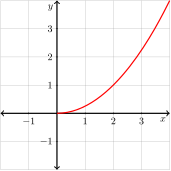

In [48]:
%%tikz

\begin{tikzpicture}
    \draw[gray,very thin] (-2,-2) grid (4,4);
    \draw[very thick,<->] (-2,0) -- (4,0) node[anchor=north east] {$x$};
    \draw[very thick,<->] (0,-2) -- (0,4) node[anchor=north east] {$y$};
    \foreach \x in {-1,1,2,3}
       \draw (\x cm,1pt) -- (\x cm,-1pt) node[anchor=north] {$\x$};
    \foreach \y in {-1,1,2,3}
        \draw (1pt,\y cm) -- (-1pt,\y cm) node[anchor=east] {$\y$};
    \draw[very thick,red] (0,0) parabola (4,4);
    % \fill[white!40!blue] (0,0) parabola (4,4);
\end{tikzpicture}

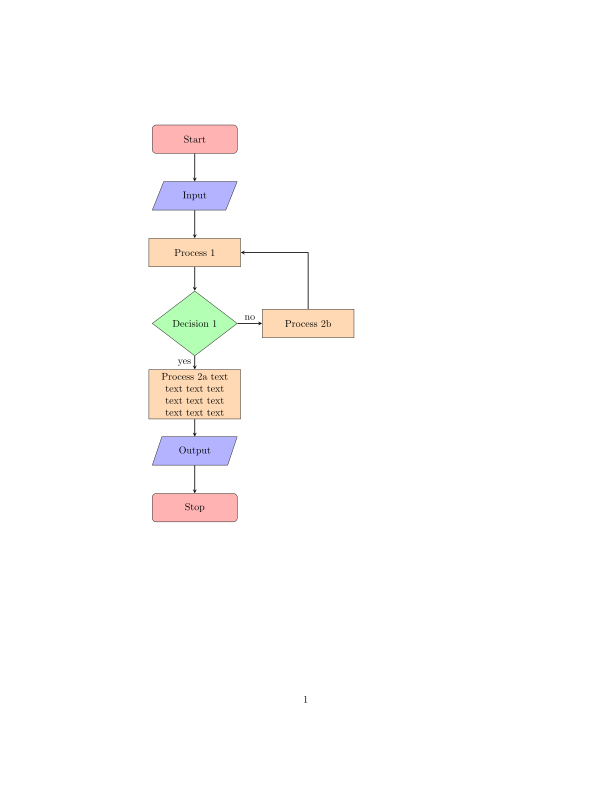

In [50]:
%%tikz -as=full-document

\documentclass{article}
\usepackage{tikz}
\usetikzlibrary{shapes.geometric, arrows}

\tikzstyle{startstop} = [rectangle, rounded corners, 
minimum width=3cm, 
minimum height=1cm,
text centered, 
draw=black, 
fill=red!30]

\tikzstyle{io} = [trapezium, 
trapezium stretches=true, % A later addition
trapezium left angle=70, 
trapezium right angle=110, 
minimum width=3cm, 
minimum height=1cm, text centered, 
draw=black, fill=blue!30]

\tikzstyle{process} = [rectangle, 
minimum width=3cm, 
minimum height=1cm, 
text centered, 
text width=3cm, 
draw=black, 
fill=orange!30]

\tikzstyle{decision} = [diamond, 
minimum width=3cm, 
minimum height=1cm, 
text centered, 
draw=black, 
fill=green!30]
\tikzstyle{arrow} = [thick,->,>=stealth]
\begin{document}

\begin{tikzpicture}[node distance=2cm]

\node (start) [startstop] {Start};
\node (in1) [io, below of=start] {Input};
\node (pro1) [process, below of=in1] {Process 1};
\node (dec1) [decision, below of=pro1, yshift=-0.5cm] {Decision 1};

\node (pro2a) [process, below of=dec1, yshift=-0.5cm] {Process 2a
text text text text
text text text 
text text text};

\node (pro2b) [process, right of=dec1, xshift=2cm] {Process 2b};
\node (out1) [io, below of=pro2a] {Output};
\node (stop) [startstop, below of=out1] {Stop};

\draw [arrow] (start) -- (in1);
\draw [arrow] (in1) -- (pro1);
\draw [arrow] (pro1) -- (dec1);
\draw [arrow] (dec1) -- node[anchor=east] {yes} (pro2a);
\draw [arrow] (dec1) -- node[anchor=south] {no} (pro2b);
\draw [arrow] (pro2b) |- (pro1);
\draw [arrow] (pro2a) -- (out1);
\draw [arrow] (out1) -- (stop);

\end{tikzpicture}
\end{document}

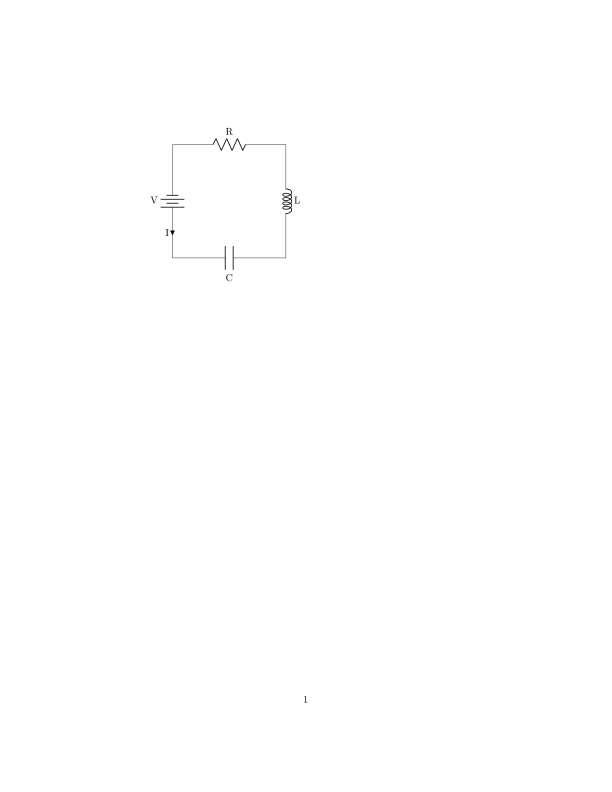

In [63]:
%%tikz -as=full-document

\documentclass{article}
\usepackage[siunitx]{circuitikz}

\begin{document}

\begin{circuitikz} 
    \draw 
        (0,0) to[battery, l=V, i=I] (0,4)
        to[R, l=R] (4,4)
        to[L, l=L] (4,0) -- (3.5,0)
        to[C, l=C] (0.5,0) -- (0,0)
        % to[lamp, *-*] (0.5,0) -- (0,0)
        % (0.5,0) -- (0.5,-2)
        % to[voltmeter] (3.5,-2) -- (3.5,0)
    ;
\end{circuitikz}

\end{document}

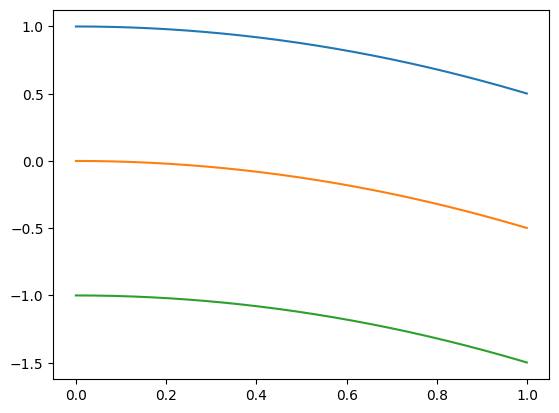

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def forward_euler(v, x0, n):
    h = 1 / n
    t = 0
    x = np.zeros((n,))
    x[0] = x0
    for i in range(1, n):
        x[i] = x[i - 1] + h * v(x[i - 1], t)
        t += h
    return x

# v = -x -> x(t) = x0 * exp(-t)
v = lambda t, x: -x
n = 1000
t = np.arange(0, 1, 1/n)

for x0 in [1, 0, -1]:
    x = forward_euler(v, x0, n)
    plt.plot(t, x)
plt.show()

In [71]:
np.arange(0, 1, 1/10)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])